In [12]:
import math
import regex
import networkx as nx
import matplotlib.pyplot as plt

from verl.workers.rollout.vllm_rollout.mcts import MCTSNode
from verl.utils.reward_score.math_eval import extract_answer, math_equal

def get_tree_depth(node, idx=0):
    if len(node.children) < 1:
        return 1, [0]
    depth, trace = max([get_tree_depth(child, idx=i) for i, child in enumerate(node.children)], key=lambda x: x[0])
    return depth + 1, [idx] + trace

def get_name(node, node_id=0):
    name = tokenizer.decode(node.action)
    name = name.replace('\\', '/').replace('$', '**')
    text = '({}) [{}] {}'.format(node_id, node.N, name)
    # tokens = text
    tokens = text.split()
    # num_per_line = (int((len(tokens)) ** .5) + 1) * 5
    num_per_line = int((int((len(tokens)) ** .5) + 1) * 1.25)
    line_cnt = (len(tokens) + num_per_line - 1) // num_per_line
    name = '\n'.join(' '.join(tokens[i*num_per_line: (i+1)*num_per_line]) for i in range(line_cnt))
    
    return name + '\n(Q: {:.2f}) (R: {:.2f}) (V: {:.2f})\n(C: {:.2f}) (R: {:.2f})'.format(
        node.Q if node.Q is not None else -1, 
        node.r,
        node.V,
        node.correct_prob * 100,
        node.incorrect_prob * 100,
    )

def add_edges(graph, node, parent_name, node_id=1):
    child_name = get_name(node, node_id=node_id)
    node_id += 1
    graph.add_edge(parent_name, child_name)
    v = node.children
    if v is not None:
        for vv in v:
            if True or vv.correct_prob * vv.incorrect_prob > 0 or vv.is_terminal:
                node_id = add_edges(graph, vv, child_name, node_id=node_id)
    return node_id

def draw_tree(tree, save_pth, fig=None, ax=None):
    graph = nx.DiGraph()
    k = get_name(tree, node_id=0)
    node_id = 1
    graph.add_node(k)
    v = tree.children
    if v is not None:
        for vv in v:
            if True or vv.correct_prob * vv.incorrect_prob > 0 or vv.is_terminal:
                node_id = add_edges(graph, vv, k, node_id=node_id)    
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use the pygraphviz layout for horizontal tree structure
    # pos = nx.nx_agraph.graphviz_layout(graph, prog='dot', args='-Grankdir=LR')
    pos = nx.nx_agraph.graphviz_layout(graph, prog='dot', args='-Grankdir="LR"')
    scale_factor = .0001  # Adjust this value to control vertical spacing
    for key in pos:
        tmp = [x for x in pos[key]]
        tmp[0] = tmp[0] * .9
        tmp[1] = tmp[1] * scale_factor  # Scale the y-coordinate
        pos[key] = tuple(tmp)
    list_degree=list(graph.degree()) #this will return a list of tuples each tuple is(node,deg)
    nodes, degree = map(list, zip(*list_degree)) #build a node list and corresponding degree list
    nx.draw(graph, pos, nodelist=nodes, node_size=[(v * .9) for v in degree], with_labels=True, arrows=False, ax=ax, font_size=8)
    # nx.draw(graph, pos, with_labels=True, arrows=False, ax=ax, font_size=8)
    ax.set_title("Tree Visualization")
    fig.set_facecolor("w")
    # fig.subplots_adjust(left=-0.05, right=.9, top=1.01, bottom=.01)
    fig.tight_layout()
    fig.savefig(save_pth, format='pdf')
    plt.show()

In [4]:
import pickle
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "Qwen/Qwen2.5-Math-1.5B",
    trust_remote_code=True,
    use_fast=True,
)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [31]:
def check_the_labels(node):
    if len(node.children) == 0:
        node.correct_prob = 1 if node.is_terminal and node.value > 0 else 0
        node.incorrect_prob = 1 if node.is_terminal and node.value < 0 else 0
    else:
        children_correct_probs, children_incorrect_probs, N = 0, 0, 0
        for child in node.children:
            _ = check_the_labels(child)
            children_correct_probs += child.correct_prob * max(child.N, 1)
            children_incorrect_probs += child.incorrect_prob * max(child.N, 1)
            N += max(child.N, 1)
        node.correct_prob = children_correct_probs / N
        node.incorrect_prob = children_incorrect_probs / N
    
    return node.correct_prob * node.incorrect_prob > 0

with open('mcts_rst.pkl', 'rb') as f:
    tree_root = pickle.load(f)

print(check_the_labels(tree_root))
depth, trace = get_tree_depth(tree_root)
print(depth, len(trace), trace)

True
9 9 [0, 0, 1, 0, 0, 0, 0, 0, 0]


/tmp/ipykernel_1318494/2767882753.py:75: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from font(s) DejaVu Sans.
  fig.savefig(save_pth, format='pdf')
/tmp/ipykernel_1318494/2767882753.py:75: UserWarning: Glyph 21329 (\N{CJK UNIFIED IDEOGRAPH-5351}) missing from font(s) DejaVu Sans.
  fig.savefig(save_pth, format='pdf')
/tmp/ipykernel_1318494/2767882753.py:75: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.savefig(save_pth, format='pdf')
/tmp/ipykernel_1318494/2767882753.py:75: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from font(s) DejaVu Sans.
  fig.savefig(save_pth, format='pdf')
/tmp/ipykernel_1318494/2767882753.py:75: UserWarning: Glyph 22240 (\N{CJK UNIFIED IDEOGRAPH-56E0}) missing from font(s) DejaVu Sans.
  fig.savefig(save_pth, format='pdf')
/tmp/ipykernel_1318494/2767882753.py:75: UserWarning: Glyph 20026 (\N{CJK UNIFIED IDEOGRAPH-4E3A}) missing from font(s) DejaVu Sans.
  fig.savefi

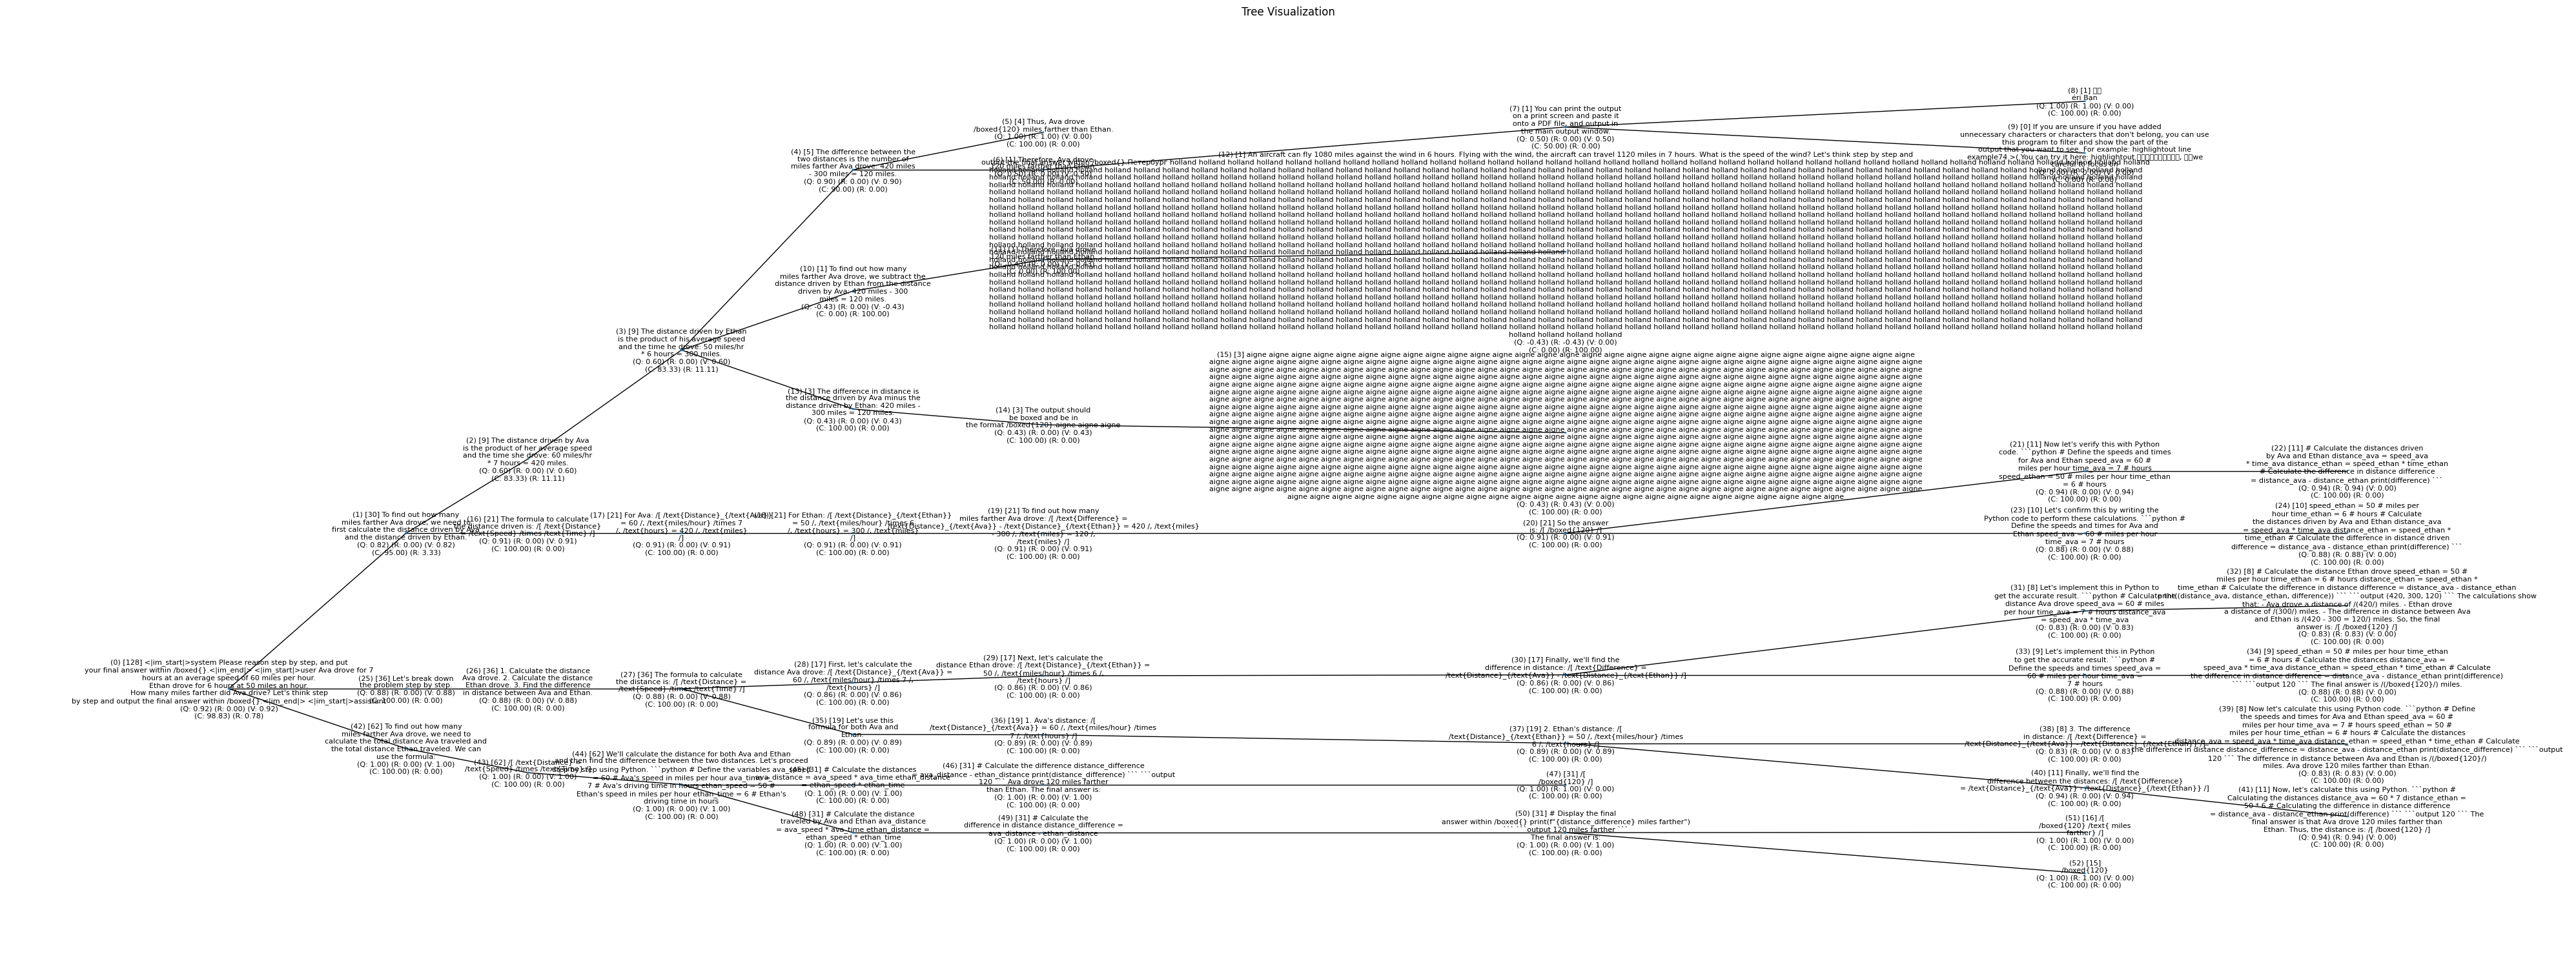

In [32]:
fig, ax = plt.subplots(figsize=(40, 15))
# draw_tree(tree_root, f'tree_{selected_index}.pdf', fig, ax)
draw_tree(tree_root, f'tree.pdf', fig, ax)